# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [253]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [254]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_train_data_7.csv", index_col=0)
test_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_test_data_7.csv", index_col=0)

In [255]:
drop_col = 'type'
train_data7 = train_data.drop(drop_col, axis=1)
test_data7 = test_data.drop(drop_col, axis=1)

# 데이터 전처리

### 새로운 Feature 추가하기

In [211]:
# 모터 전류 당 공기 유량은 압축기의 효율성
train_data7['air_inflow_per_motor_current'] = train_data7['air_inflow'] / train_data7['motor_current']	
test_data7['air_inflow_per_motor_current'] = test_data7['air_inflow'] / test_data7['motor_current']

# # 압축기와 모터의 상태를 모두 고려한 압축기 효율1
# new_train_data7['Compressor_Efficiency1'] = new_train_data7['out_pressure'] * new_train_data7['air_inflow'] / new_train_data7['motor_current'] / 3.5168 / new_train_data7['hp']
# test_data7['Compressor_Efficiency1'] = test_data7['out_pressure'] * test_data7['air_inflow'] / test_data7['motor_current'] / 3.5168 / test_data7['hp']

# # 압축기와 모터의 상태를 모두 고려한 압축기 효율2
# new_train_data7['Motor_Efficiency'] = (new_train_data7['motor_current'] * new_train_data7['motor_rpm'] * new_train_data7['hp']) / (746 * 1000)
# test_data7['Motor_Efficiency'] = (test_data7['motor_current'] * test_data7['motor_rpm'] * test_data7['hp']) / (746 * 1000)

# # 압축기의 효율2
# new_train_data7['Compressor_Efficiency2'] = (new_train_data7['out_pressure'] * new_train_data7['air_inflow'] * (new_train_data7['air_end_temp'] - 25)) / (new_train_data7['motor_current'] * new_train_data7['motor_vibe'] * new_train_data7['hp'] * 3.6)
# test_data7['Compressor_Efficiency2'] = (test_data7['out_pressure'] * test_data7['air_inflow'] * (test_data7['air_end_temp'] - 25)) / (test_data7['motor_current'] * test_data7['motor_vibe'] * test_data7['hp'] * 3.6)

# 압축기의 배출량
train_data7['Discharge_Volume'] = (train_data7['air_inflow'] / 60) * ((train_data7['air_end_temp'] + 273) / 273) * (train_data7['out_pressure'] / 1.01325)
test_data7['Discharge_Volume'] = (test_data7['air_inflow'] / 60) * ((test_data7['air_end_temp'] + 273) / 273) * (test_data7['out_pressure'] / 1.01325)

# # 공기의 밀도
# train_data7['air_density'] = train_data7['out_pressure'] / (287 * (train_data7['air_end_temp'] + 273))
# test_data7['air_density'] = test_data7['out_pressure'] / (287 * (test_data7['air_end_temp'] + 273))

In [212]:
# 이전 시간대 대비 차이 계산 (delta)
df_delta = train_data7.diff(periods=1)
df_delta.columns = [col+"_delta" for col in train_data7.columns]

# 이전 시간대 대비 변화율 계산 (delta rate)
df_delta_rate = train_data7.pct_change(periods=1)
df_delta_rate.columns = [col+"_delta_rate" for col in train_data7.columns]

# 이동평균 계산 (moving average)
window_size = 3 # 윈도우 크기
df_ma3 = train_data7.rolling(window_size).mean()
df_ma3.columns = [col+"_ma3" for col in train_data7.columns]

# 이동평균 계산 (moving average)
window_size = 5 # 윈도우 크기
df_ma5 = train_data7.rolling(window_size).mean()
df_ma5.columns = [col+"_ma5" for col in train_data7.columns]

# 이동평균 계산 (moving average)
window_size = 10 # 윈도우 크기
df_ma10 = train_data7.rolling(window_size).mean()
df_ma10.columns = [col+"_ma10" for col in train_data7.columns]

# 상관관계 계산 (correlation)
df_corr = train_data7.corr()

# 새로운 feature들을 데이터프레임에 추가하기
df_train = pd.concat([train_data7, df_delta, df_delta_rate, df_ma3, df_ma5, df_ma10], axis=1)

# # 상관관계 행렬을 csv 파일로 저장하기
# df_corr.to_csv("correlation_matrix.csv")

# 맨 처음과 맨 마지막 데이터의 결측치 처리하기
df_train = df_train.fillna(method="bfill").fillna(method="ffill")

In [213]:
# 이전 시간대 대비 차이 계산 (delta)
df_delta = test_data7.diff(periods=1)
df_delta.columns = [col+"_delta" for col in test_data7.columns]

# 이전 시간대 대비 변화율 계산 (delta rate)
df_delta_rate = test_data7.pct_change(periods=1)
df_delta_rate.columns = [col+"_delta_rate" for col in test_data7.columns]

# 이동평균 계산 (moving average)
window_size = 3 # 윈도우 크기
df_ma3 = test_data7.rolling(window_size).mean()
df_ma3.columns = [col+"_ma3" for col in test_data7.columns]

# 이동평균 계산 (moving average)
window_size = 5 # 윈도우 크기
df_ma5 = test_data7.rolling(window_size).mean()
df_ma5.columns = [col+"_ma5" for col in test_data7.columns]

# 이동평균 계산 (moving average)
window_size = 10 # 윈도우 크기
df_ma10 = test_data7.rolling(window_size).mean()
df_ma10.columns = [col+"_ma10" for col in test_data7.columns]

# 상관관계 계산 (correlation)
df_corr = test_data7.corr()

# 새로운 feature들을 데이터프레임에 추가하기
df_test = pd.concat([test_data7, df_delta, df_delta_rate, df_ma3, df_ma5, df_ma10], axis=1)

# # 상관관계 행렬을 csv 파일로 저장하기
# df_corr.to_csv("correlation_matrix.csv")

# 맨 처음과 맨 마지막 데이터의 결측치 처리하기
df_test = df_test.fillna(method="bfill").fillna(method="ffill")

# 모델링

### PyTorch 모델링

In [214]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

In [215]:
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
fix_seed(42)

In [216]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [217]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim1),
#             nn.ReLU(),
#             nn.Linear(hidden_dim1, hidden_dim2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim2, encoding_dim), # 추가된 히든 레이어
#             nn.ReLU() # 추가된 히든 레이어
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, hidden_dim2), # 추가된 히든 레이어
#             nn.ReLU(), # 추가된 히든 레이어
#             nn.Linear(hidden_dim2, hidden_dim1),
#             nn.ReLU(),
#             nn.Linear(hidden_dim1, input_dim),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [218]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train)
test_data_scaled = scaler.transform(df_test)

# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [219]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim1 = 32
hidden_dim2 = 64

model = Autoencoder()

# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 100
count = 0

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=54, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=54, bias=True)
  )
)


In [220]:
model_name = 'type7_timeSeries_plus2'

In [221]:
for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(model(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.9070042538386519, val loss: 12.575840950012207
Epoch 2, train loss: 0.8809658071046235, val loss: 12.47021484375
Epoch 3, train loss: 0.8394114791706044, val loss: 12.337355613708496
Epoch 4, train loss: 0.7742617925008138, val loss: 12.1796236038208
Epoch 5, train loss: 0.6817150628694923, val loss: 12.016695976257324
Epoch 6, train loss: 0.5699873432036369, val loss: 11.879302024841309
Epoch 7, train loss: 0.45803904277022167, val loss: 11.78283977508545
Epoch 8, train loss: 0.3628822449714907, val loss: 11.741889953613281
Epoch 9, train loss: 0.2980282742490051, val loss: 11.646929740905762
Epoch 10, train loss: 0.2581082595291958, val loss: 11.507570266723633
Epoch 11, train loss: 0.232976592997069, val loss: 11.3611478805542
Epoch 12, train loss: 0.21549401231991347, val loss: 11.198928833007812
Epoch 13, train loss: 0.20219547261473952, val loss: 11.010408401489258
Epoch 14, train loss: 0.19079871331491777, val loss: 10.798285484313965
Epoch 15, train loss:

In [222]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = model(test_data_scaled)
# test_data_reconstructed

In [223]:
reconstruction_error = torch.mean(torch.square(test_data_scaled - test_data_reconstructed), axis=1)
# reconstruction_error

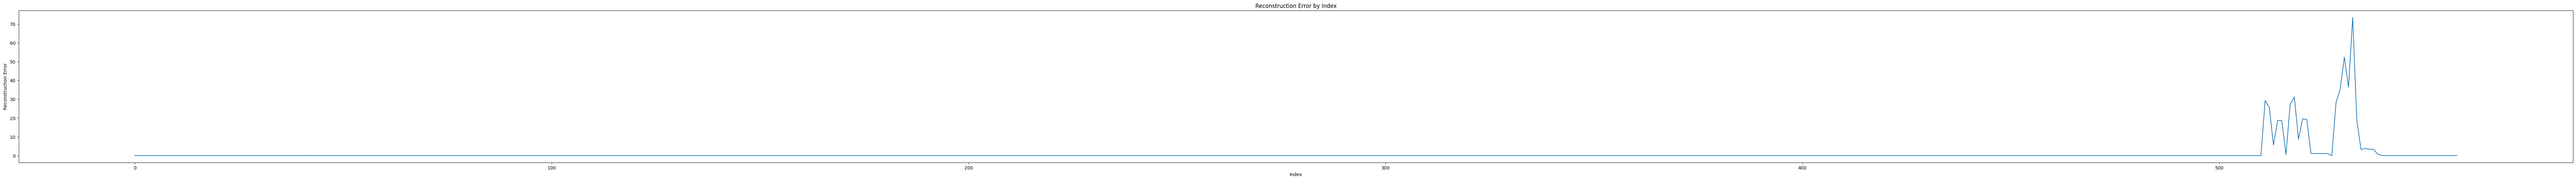

In [224]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.figure(figsize=(100,6))
plt.plot(range(len(reconstruction_error)), reconstruction_error.detach().numpy())
# plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

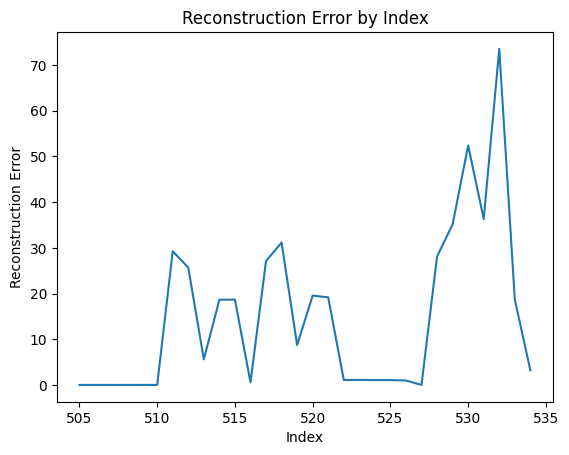

In [225]:
# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 505
end_index = 535
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

In [230]:
# 527이 이상함
start_idx = 520
end_idx = 526
reconstruction_error_min = torch.min(reconstruction_error[start_idx:end_idx+1])

x = float(reconstruction_error_min)
x

0.9748245477676392

In [227]:
start_idx = 510
end_idx = 530
reconstruction_error_mean = torch.mean(reconstruction_error[start_idx:end_idx+1])

z = float(reconstruction_error_mean)
z

15.47747802734375

In [231]:
start_idx = 0
end_idx = 510
reconstruction_error_max = torch.max(reconstruction_error[start_idx:end_idx+1])

y = float(reconstruction_error_max)
y

0.032797686755657196

In [244]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 95.153)
threshold

0.03398557643001935

In [245]:
# Predict anomalies in test_data
test_prediction7 = (reconstruction_error.detach().numpy() > threshold).astype(int)

# 데이터 저장

In [247]:
from collections import Counter

count = Counter(test_prediction7)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  531
Number of 1s:  27


In [248]:
file_name = model_name + '_th95153'

In [249]:
# 코랩에 저장
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': test_prediction7}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")

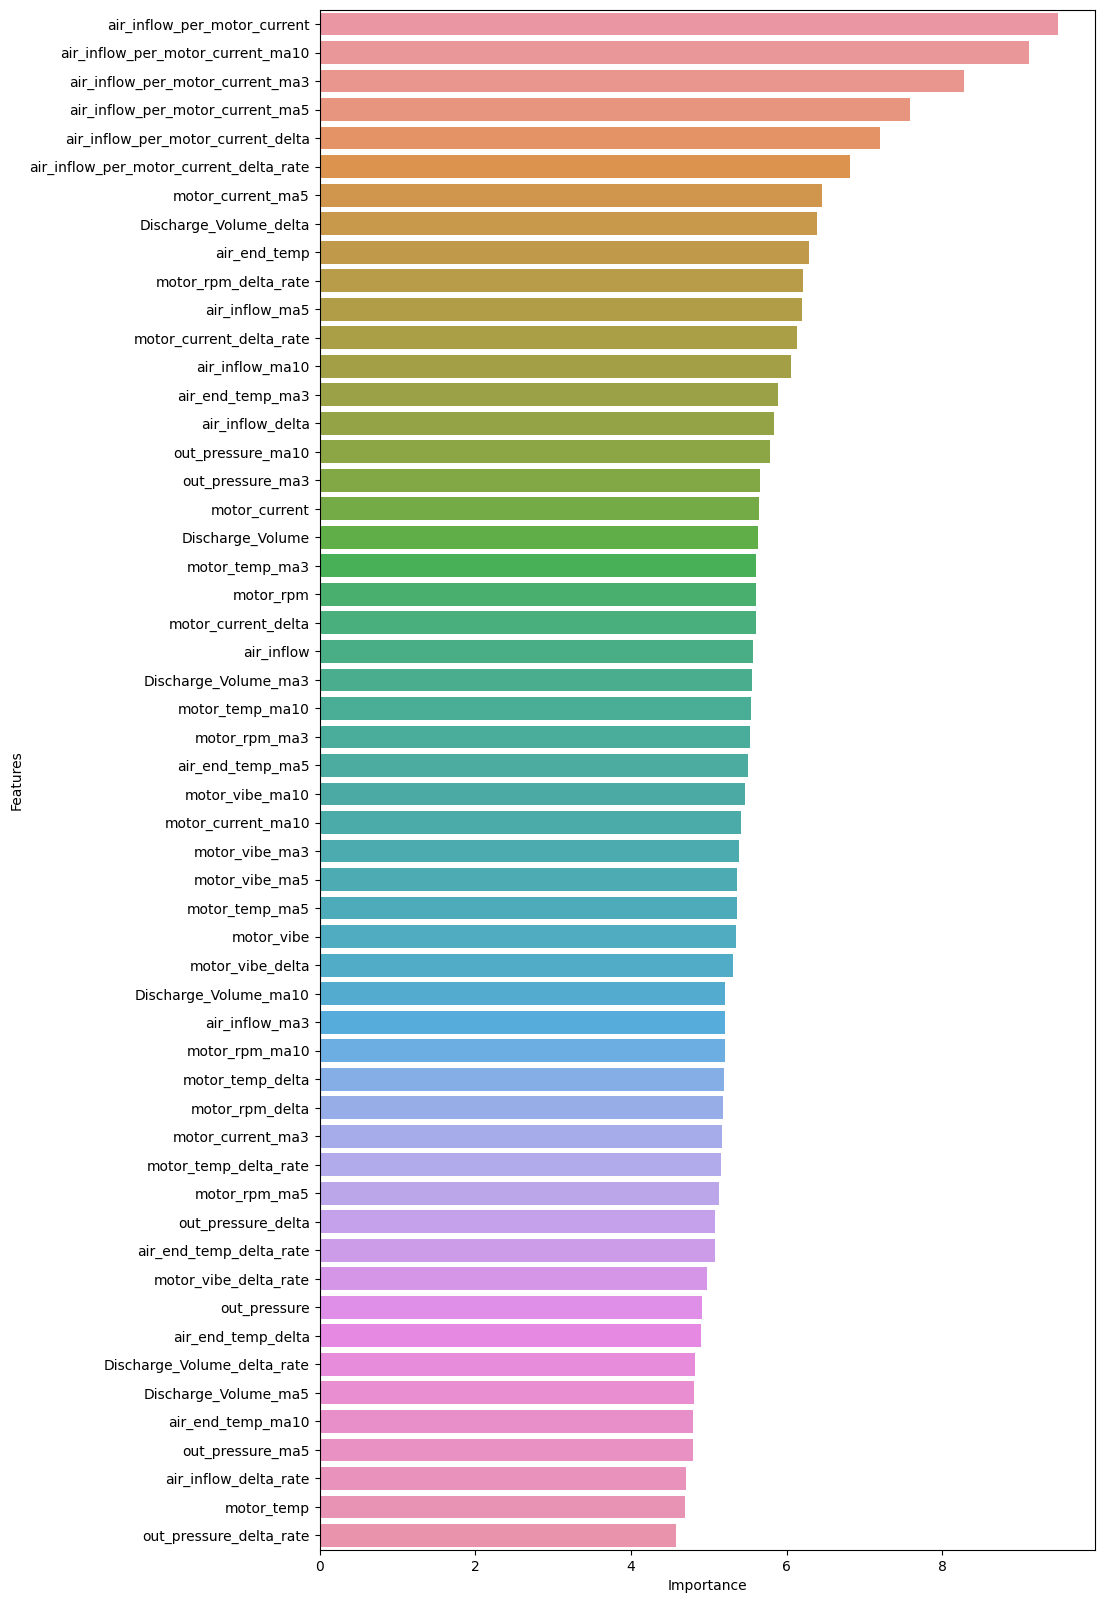

In [252]:
# 가중치 추출
encoder_weights = model.encoder[0].weight.data.numpy()
decoder_weights = model.decoder[0].weight.data.numpy()

# 각 feature의 중요도 계산
importance = np.abs(np.vstack([encoder_weights, decoder_weights[:, :54]])).sum(axis=0)

# 중요도가 높은 feature 순서대로 출력
sorted_idx = np.argsort(importance)[::-1]
feature_names = df_test.columns  # 입력 데이터의 각 열에 대한 이름 리스트
sorted_feature_names = [feature_names[idx] for idx in sorted_idx]
sorted_importance = importance[sorted_idx]

# 중요도가 높은 feature 순서대로 그래프 그리기
plt.figure(figsize=(10, 20))
sns.barplot(y=sorted_feature_names, x=sorted_importance)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()